In [1]:
#Import Library
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Set path to extracted folder inside Google Drive
dataset_path = "/content/drive/MyDrive/dogSkinDisease"

# Verify if the folder exists
if os.path.exists(dataset_path):
    print("Folder exists. Listing files:")
    print(os.listdir(dataset_path))
else:
    print("Folder not found. Please check the path.")

Folder exists. Listing files:
['test', 'train', 'validation']


In [12]:
# Verify if the dataset folder exists
if os.path.exists(dataset_path):
    print("Dataset folder exists.")
else:
    print("Dataset folder NOT found. Please check the path.")

# Number of images in each class for the training set
print(f"There are {len(os.listdir(os.path.join(dataset_path, 'train/flea_allergy')))} train set images of flea allergy.")
print(f"There are {len(os.listdir(os.path.join(dataset_path, 'train/hotspot')))} train set images of hotspot.")
print(f"There are {len(os.listdir(os.path.join(dataset_path, 'train/mange')))} train set images of mange.")
print(f"There are {len(os.listdir(os.path.join(dataset_path, 'train/ringworm')))} train set images of ringworm.")
print()

# Number of images in each class for the validation set
print(f"There are {len(os.listdir(os.path.join(dataset_path, 'validation/flea_allergy')))} val set images of flea allergy.")
print(f"There are {len(os.listdir(os.path.join(dataset_path, 'validation/hotspot')))} val set images of hotspot.")
print(f"There are {len(os.listdir(os.path.join(dataset_path, 'validation/mange')))} val set images of mange.")
print(f"There are {len(os.listdir(os.path.join(dataset_path, 'validation/ringworm')))} val set images of ringworm.")
print()

# Number of images in each class for the testing set
print(f"There are {len(os.listdir(os.path.join(dataset_path, 'test/flea_allergy')))} test set images of flea allergy.")
print(f"There are {len(os.listdir(os.path.join(dataset_path, 'test/hotspot')))} test set images of hotspot.")
print(f"There are {len(os.listdir(os.path.join(dataset_path, 'test/mange')))} test set images of mange.")
print(f"There are {len(os.listdir(os.path.join(dataset_path, 'test/ringworm')))} test set images of ringworm.")


Dataset folder exists.
There are 76 train set images of flea allergy.
There are 96 train set images of hotspot.
There are 63 train set images of mange.
There are 138 train set images of ringworm.

There are 20 val set images of flea allergy.
There are 20 val set images of hotspot.
There are 20 val set images of mange.
There are 20 val set images of ringworm.

There are 20 test set images of flea allergy.
There are 20 test set images of hotspot.
There are 20 test set images of mange.
There are 20 test set images of ringworm.


In [14]:
# Define the correct dataset path in Google Drive
DATASET_DIR = "/content/drive/MyDrive/dogSkinDisease"

# Paths for train, validation, and test directories
TRAINING_DIR = os.path.join(DATASET_DIR, "train")
VALIDATION_DIR = os.path.join(DATASET_DIR, "validation")
TEST_DIR = os.path.join(DATASET_DIR, "test")  # Changed from "testing" to "test"

# Paths for each class in the training, validation, and test sets
TRAINING_FLEA_DIR = os.path.join(TRAINING_DIR, "flea_allergy")
VALIDATION_FLEA_DIR = os.path.join(VALIDATION_DIR, "flea_allergy")
TEST_FLEA_DIR = os.path.join(TEST_DIR, "flea_allergy")

TRAINING_HOTSPOT_DIR = os.path.join(TRAINING_DIR, "hotspot")
VALIDATION_HOTSPOT_DIR = os.path.join(VALIDATION_DIR, "hotspot")
TEST_HOTSPOT_DIR = os.path.join(TEST_DIR, "hotspot")  # Fixed variable name

TRAINING_MANGE_DIR = os.path.join(TRAINING_DIR, "mange")
VALIDATION_MANGE_DIR = os.path.join(VALIDATION_DIR, "mange")
TEST_MANGE_DIR = os.path.join(TEST_DIR, "mange")  # Fixed variable name

TRAINING_RINGWORM_DIR = os.path.join(TRAINING_DIR, "ringworm")
VALIDATION_RINGWORM_DIR = os.path.join(VALIDATION_DIR, "ringworm")
TEST_RINGWORM_DIR = os.path.join(TEST_DIR, "ringworm")  # Fixed variable name

# Print to verify paths
print(f"Training directory: {TRAINING_DIR}")
print(f"Validation directory: {VALIDATION_DIR}")
print(f"Test directory: {TEST_DIR}")  # Updated variable

Training directory: /content/drive/MyDrive/dogSkinDisease/train
Validation directory: /content/drive/MyDrive/dogSkinDisease/validation
Test directory: /content/drive/MyDrive/dogSkinDisease/test


In [15]:
# Function to create training and validation generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

    # Data augmentation for training set
    train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                       fill_mode='nearest',
                                       # Enable these for data augmentation
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True
                                       )

    # Training data generator
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=16,
                                                        class_mode='categorical',
                                                        target_size=(150, 150))

    # No augmentation for validation data (only rescaling)
    validation_datagen = ImageDataGenerator(rescale=1.0 / 255.)

    # Validation data generator
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=16,
                                                                  class_mode='categorical',
                                                                  target_size=(150, 150))
    return train_generator, validation_generator

# Create generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 373 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


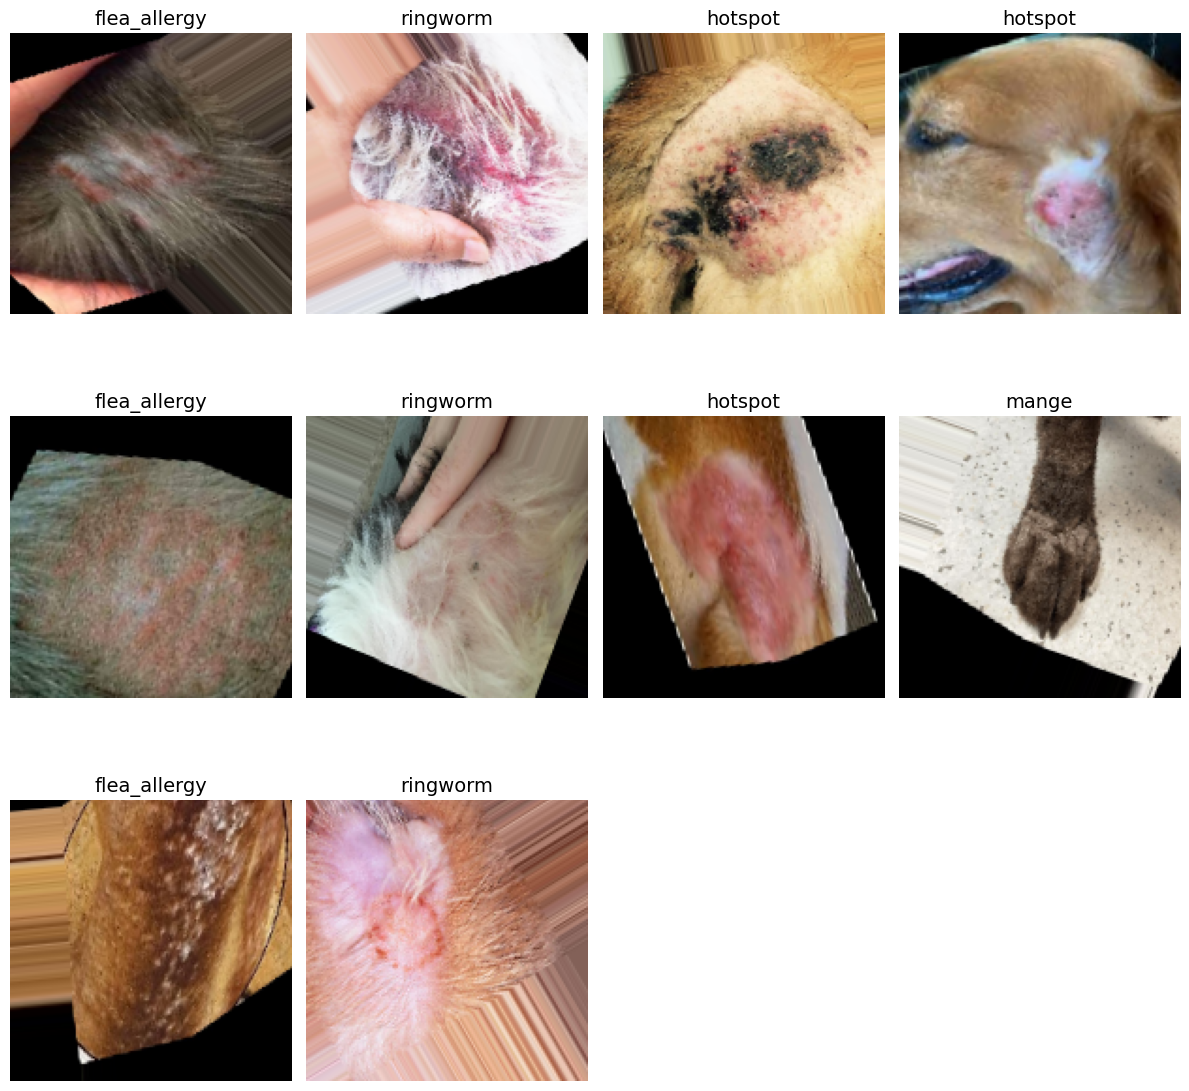

In [16]:
# Function to show sample images from a generator
def show_image_samples(gen):
    class_dict = gen.class_indices  # Get class names from the generator
    classes = list(class_dict.keys())  # Convert class indices to a list

    images, labels = next(gen)  # Get a sample batch from generator

    plt.figure(figsize=(12, 12))  # Adjusted size for better visualization
    num_samples = min(len(labels), 10)  # Show up to 10 images

    for i in range(num_samples):
        plt.subplot(3, 4, i+1)  # Creates a grid layout
        plt.imshow(images[i])  # Show the image
        index = np.argmax(labels[i])  # Get the predicted class index
        plt.title(classes[index], color='black', fontsize=14)  # Assign class name as title
        plt.axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Example usage
show_image_samples(train_generator)

In [17]:
# Function to create the CNN model
def create_model():
    model = tf.keras.models.Sequential([
        # Convolutional Layer
        tf.keras.layers.Conv2D(8, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),  # Reduce spatial dimensions

        # Second Convolutional Layer (for better feature extraction)
        tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        # Flatten layer to transition to Dense layers
        tf.keras.layers.Flatten(),

        # Fully connected layers
        tf.keras.layers.Dense(64, activation='relu'),  # Increased neurons for better learning
        tf.keras.layers.Dropout(0.2),  # Regularization to prevent overfitting
        tf.keras.layers.Dense(32, activation='relu'),

        # Output Layer with 4 categories (Softmax for multiclass classification)
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Explicit learning rate
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [18]:
model = create_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,327,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,330,772 (5.08 MB)

 Trainable params: 1,330,772 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Mendefenisikan fungsi Callback
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.00001,
    verbose=1,
)

# Model Checkpoint
checkpoint_path = 'model_checkpoints/SkinDisease.weights.h5' # Changed the file path from '.h5' to '.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Check if the directory exists, and create it if it does not
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [25]:
history = model.fit(train_generator,
            epochs=50,
            validation_data=validation_generator,
            verbose = 1,
            callbacks = [early_stopping, checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3538 - loss: 1.4235
Epoch 1: val_loss improved from inf to 1.40013, saving model to model_checkpoints/SkinDisease.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step - accuracy: 0.3538 - loss: 1.4222 - val_accuracy: 0.2875 - val_loss: 1.4001
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.3162 - loss: 1.3646
Epoch 2: val_loss did not improve from 1.40013
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.3178 - loss: 1.3646 - val_accuracy: 0.2500 - val_loss: 1.4091
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.3422 - loss: 1.3664
Epoch 3: val_loss improved from 1.40013 to 1.38146, saving model to model_checkpoints/SkinDisease.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.3425 - loss: 1.3662 - val_accuracy: 0.2500 - val_loss: 1.3815
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.3506 - loss: 1.3305
Epoch 4: val_loss improved from 1.38146 to 1.371

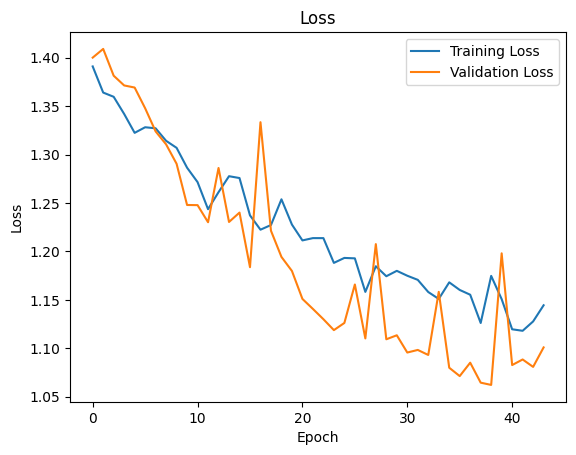

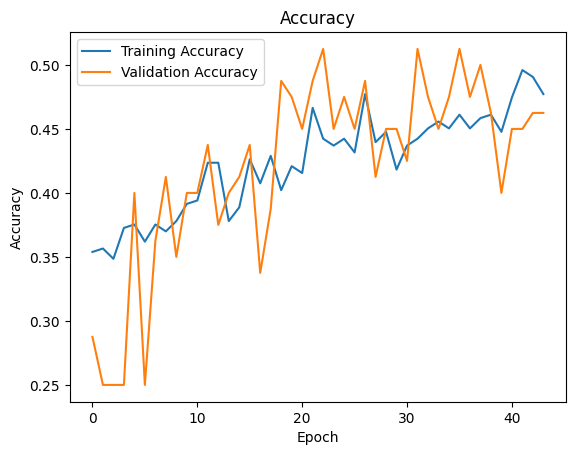

In [26]:
# Obtain training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Draw loss plot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()
print()

# Draw accuracy plot
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [29]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the correct test directory path using the DATASET_DIR variable
TEST_DIR = os.path.join(DATASET_DIR, "test")

# Define ImageDataGenerator for testing (Only Rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.)

# Load test images from the directory
test_set_2 = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    batch_size=16,
    class_mode='categorical',
    target_size=(150, 150)  # Resize images to 150x150
)

Found 80 images belonging to 4 classes.


In [30]:
Y_pred_2 = model.predict(test_set_2)
y_pred_2 = np.argmax(Y_pred_2, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step


In [31]:
print(classification_report(test_set_2.classes, y_pred_2))

              precision    recall  f1-score   support

           0       0.40      0.10      0.16        20
           1       0.25      0.10      0.14        20
           2       0.30      0.30      0.30        20
           3       0.26      0.60      0.36        20

    accuracy                           0.28        80
   macro avg       0.30      0.28      0.24        80
weighted avg       0.30      0.28      0.24        80



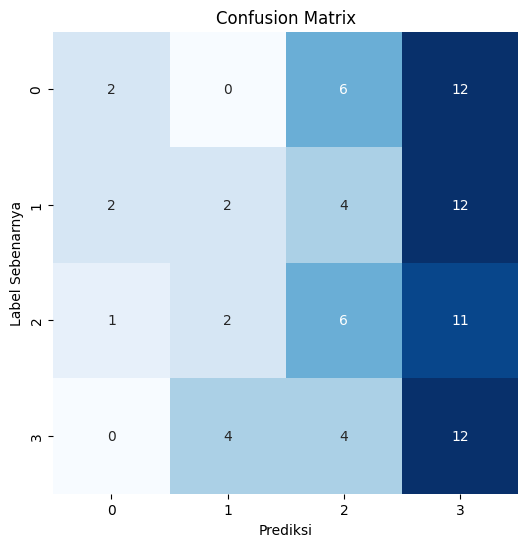

In [32]:
# Misalkan test_set_2.classes adalah label yang sebenarnya dan y_pred_2 adalah label prediksi
y_true = test_set_2.classes  # Label yang sebenarnya
y_pred = y_pred_2  # Label prediksi

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix dalam bentuk heatmap
class_names = ['0', '1', '2', '3']  # Nama kelas (sesuaikan dengan kelas Anda)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

In [33]:
#Save model to h5 format

model.save("SkinDisease.h5")

In [34]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1.0/225.)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['flea_allergy', 'hotspot', 'mange', 'ringworm']
  df['Animal'] = prod
  df = df[['Animal', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'flea_allergy'
  elif predict_label == 1:
      predict_product = 'hotspot'
  elif predict_label == 2:
      predict_product = 'mange'
  else:
      predict_product = 'ringworm'

  return predict_product, df

Saving ringworm (7).jpg to ringworm (7).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step




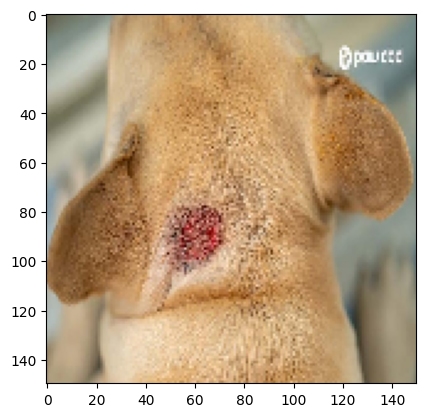


The image is detected as ringworm


         Animal  Probability
0  flea_allergy     0.144787
1       hotspot     0.357619
2         mange     0.002869
3      ringworm     0.494725




In [35]:
from keras.preprocessing import image
from google.colab import files


uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = tf.keras.preprocessing.image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')